In [1]:
onColab = False
driveDir = "google_colab_extension"

In [2]:
import os
import re
import shutil
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, r2_score

import tqdm
import dill
import pathlib
import datetime
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

if onColab:
    import sys
    sys.path.append(f"/content/drive/MyDrive/{driveDir}")
import D01_1_DataPreparation
import Z01_1_General

C:\Users\estel\AppData\Local\Temp\ipykernel_9940\2608942391.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
version = "LSTM_MHA_01_pytorch_vanila"

if onColab:
    # directories
    parentDir = f"/content/drive/MyDrive/{driveDir}/"
else:
    parentDir = ""

rawDataDir = f"{parentDir}raw_data"
preparedDataDir = f"{parentDir}prepared_data"
preparedDataPlots = f"plots/prepared_data"
testValidDataDir = f"{parentDir}testing_and_validation_data"
modelDir = f"{parentDir}models/{version}"
scalerDir = f"scalers/{version}"
lossDir = f"{parentDir}losses/{version}"
checkpointDir = f"{parentDir}general_checkpoint/{version}"
learingCurveDir = f"{parentDir}learning_curve/{version}"

pathlib.Path(f"{modelDir}/").mkdir(parents=True, exist_ok=True)
pathlib.Path(f"{checkpointDir}/").mkdir(parents=True, exist_ok=True)
pathlib.Path(f"{lossDir}/").mkdir(parents=True, exist_ok=True)
pathlib.Path(f"{learingCurveDir}/").mkdir(parents=True, exist_ok=True)

In [4]:
# prepare raw data or no
boPrepRawData = False

if boPrepRawData:
    D01_1_DataPreparation.prepareData(rawDataDir, preparedDataDir)

In [5]:
# Generate dataset
print('== Generate Datasets ==')
train_data_files, test_data_files, valid_data_files = D01_1_DataPreparation.splitDatasets(testValidDataDir, preparedDataDir)

== Generate Datasets ==


In [6]:
# combine data, then scale all together
n_steps = 300
train_df = pd.DataFrame()
for file in train_data_files:
    data_path = f"{preparedDataDir}/sensor data/{file}"
    df, status = D01_1_DataPreparation.loadDataset(data_path, Z01_1_General.DATEFORMAT)
    train_df = pd.concat([train_df, df], axis=0)

test_df = pd.DataFrame()
for file in test_data_files:
    data_path = f"{preparedDataDir}/sensor data/{file}"
    df, status = D01_1_DataPreparation.loadDataset(data_path, Z01_1_General.DATEFORMAT)
    test_df = pd.concat([test_df, df], axis=0)

In [7]:
tempCols = [c for c in train_df.columns if re.match('temp', c)]
humdCols = [c for c in train_df.columns if re.match('humid', c)]
miscCols = [c for c in train_df.columns if not re.match('(temp|humid)', c)]
xCols = tempCols + humdCols + miscCols

tempScaler = MinMaxScaler(feature_range=(0,1)).fit(train_df.loc[:, tempCols])
humdScaler = MinMaxScaler(feature_range=(0,1)).fit(train_df.loc[:, humdCols])
miscScaler = MinMaxScaler(feature_range=(0,1)).fit(train_df.loc[:, miscCols])
lsScalers = [tempScaler, humdScaler, miscScaler]

def scaleData(df, lsScalers):
    tempScaler, humdScaler, miscScaler = lsScalers
    dfTempCols = pd.DataFrame(tempScaler.transform(df.loc[:, tempCols]), index=df.index, columns=tempCols)
    dfHumdCols = pd.DataFrame(humdScaler.transform(df.loc[:, humdCols]), index=df.index, columns=humdCols)
    dfMiscCols = pd.DataFrame(miscScaler.transform(df.loc[:, miscCols]))
    dfMiscCols.columns = miscCols
    dfMiscCols.index = df.index

    dfScl = pd.concat([dfTempCols, dfHumdCols, dfMiscCols], axis=1)
    return dfScl

def descaleData(df, lsScalers):
    tempScaler, humdScaler, miscScaler = lsScalers
    dfTempCols = pd.DataFrame(tempScaler.inverse_transform(df.loc[:, tempCols]), index=df.index, columns=tempCols)
    dfHumdCols = pd.DataFrame(humdScaler.inverse_transform(df.loc[:, humdCols]), index=df.index, columns=humdCols)
    dfMiscCols = pd.DataFrame(miscScaler.inverse_transform(df.loc[:, miscCols]))
    dfMiscCols.columns = miscCols
    dfMiscCols.index = df.index

    dfScl = pd.concat([dfTempCols, dfHumdCols, dfMiscCols], axis=1)
    return dfScl

In [8]:
# processing for training data
# scale and transform data

# combine data, then scale all together
train_df = pd.DataFrame()
for file in train_data_files:
    data_path = f"{preparedDataDir}/sensor data/{file}"
    df, status = D01_1_DataPreparation.loadDataset(data_path, Z01_1_General.DATEFORMAT)
    train_df = pd.concat([train_df, df], axis=0)

test_df = pd.DataFrame()
for file in test_data_files:
    data_path = f"{preparedDataDir}/sensor data/{file}"
    df, status = D01_1_DataPreparation.loadDataset(data_path, Z01_1_General.DATEFORMAT)
    test_df = pd.concat([test_df, df], axis=0)

In [9]:
n_steps = 300
for file in train_data_files:
    sensor_df, status = D01_1_DataPreparation.loadDataset(f"{preparedDataDir}/sensor data/{file}", Z01_1_General.DATEFORMAT)

    # print(len(df), 'before scale from main')
    df = scaleData(sensor_df, lsScalers)
    # print(len(df), 'after scale from main')

    x_data, y_data = D01_1_DataPreparation.transformDataSingleStep(df, n_steps)

    if file == train_data_files[0]:
        x_train = x_data
        y_train = y_data
    else:
        x_train = np.concatenate([x_train, x_data], axis=0)
        y_train = np.concatenate([y_train, y_data], axis=0)

for file in test_data_files:
    sensor_df, status = D01_1_DataPreparation.loadDataset(f"{preparedDataDir}/sensor data/{file}", Z01_1_General.DATEFORMAT)

    # print(len(df), 'before scale from main')
    df = scaleData(sensor_df, lsScalers)
    # print(len(df), 'after scale from main')

    x_data, y_data = D01_1_DataPreparation.transformDataSingleStep(df, n_steps)

    if file == test_data_files[0]:
        x_test = x_data
        y_test = y_data
    else:
        x_test = np.concatenate([x_test, x_data], axis=0)
        y_test = np.concatenate([y_test, y_data], axis=0)

In [10]:
print("Data Description")
print("x_train: ", x_train.shape, "y_train: ", y_train.shape)
print("x_test: ", x_test.shape, "y_test: ", y_test.shape)

Data Description
x_train:  (15392, 300, 14) y_train:  (15392, 14)
x_test:  (4586, 300, 14) y_test:  (4586, 14)


### Split dataset to half, workaround for limited RAM

In [11]:
spliDataset2Half = True
if spliDataset2Half:
    x_train_1 = x_train[:8000, :]
    y_train_1 = y_train[:8000, :]

    x_train_2 = x_train[8000:, :]
    y_train_2 = y_train[8000:, :]

x_train_1 = np.float32(x_train_1)
y_train_1 = np.float32(y_train_1)
x_train_2 = np.float32(x_train_2)
y_train_2 = np.float32(y_train_2)
x_test = np.float32(x_test)
y_test = np.float32(y_test)

# Setup pytorch

In [12]:
rs = 1
torch.manual_seed(rs)

dtypeDefault = torch.float32
torch.set_default_dtype(dtypeDefault)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu' # when saving model to deploy, use cpu to avoid troubles
print(f'Using {device} device')

Using cpu device


In [13]:
class DSet(Dataset):
    def __init__(self, xArr, yArr):
        self.x = torch.tensor(xArr)
        self.y = torch.tensor(yArr)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

## Model architecture

In [14]:
nFeatures = len(train_df.columns)
seqLen = len(x_train[0])
nHeads = 8
nHiddenLSTM = 128
nHiddenLinear1 = nHiddenLSTM*seqLen
nHiddenLinear2 = 512
nHiddenLinear3 = 256
batchSz = 16
nEpochs = 1000
lr = 1e-6

In [15]:
class LstmMHAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(nFeatures, nHiddenLSTM, 1, batch_first=True)
        self.relu1 = nn.ReLU()
        # self.dropout1 = nn.Dropout(0.2)
        self.MHA2 = nn.MultiheadAttention(nHiddenLSTM, nHeads, batch_first=True)
        self.linear3 = nn.Linear(nHiddenLinear1, nHiddenLinear2)
        self.relu2 = nn.ReLU()
        # self.dropout2 = nn.Dropout(0.2)
        self.linear4 = nn.Linear(nHiddenLinear2, nHiddenLinear3)
        self.relu3 = nn.ReLU()
        # self.dropout3 = nn.Dropout(0.2)
        self.linear5 = nn.Linear(nHiddenLinear3, nFeatures)


    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.relu1(x)
        # x = self.dropout1(x)
        x = self.MHA2(x, x, x)[0] # take only attn output
        x = x.reshape(x.shape[0], -1)
        x = self.linear3(x)
        x = self.relu2(x)
        # x = self.dropout2(x)
        x = self.linear4(x)
        x = self.relu3(x)
        # x = self.dropout3(x)
        x = self.linear5(x)


        return x

In [18]:
model = LstmMHAModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
lossFn = nn.MSELoss()

### Training with first half

In [19]:
# Use the first half of dataset first
if spliDataset2Half:
    xTrainTs = torch.Tensor(x_train_1)
    yTrainTs = torch.Tensor(y_train_1)
    xTestTs = torch.Tensor(x_test)
    yTestTs = torch.Tensor(y_test)
else:
    xTrainTs = torch.Tensor(x_train)
    yTrainTs = torch.Tensor(y_train)
    xTestTs = torch.Tensor(x_test)
    yTestTs = torch.Tensor(y_test)

### Data Loader ###
params = {'shuffle': True, 'batch_size': batchSz}

if spliDataset2Half:
    loaderTrain = DataLoader(DSet(x_train_1, y_train_1), **params)
    loaderTest = DataLoader(DSet(x_test, y_test), **params)
else:
    loaderTrain = DataLoader(DSet(x_train, y_train), **params)
    loaderTest = DataLoader(DSet(x_test, y_test), **params)

  0%|          | 0/1000 [00:00<?, ?epoch/s]

Epoch 0: train RMSE 0.347798, test RMSE 0.333623:   0%|          | 1/1000 [03:11<53:07:55, 191.47s/epoch]

Epoch 0: train RMSE 0.347798, test RMSE 0.333623


Epoch 44: train RMSE 0.082088, test RMSE 0.118180:   4%|▍         | 44/1000 [2:50:35<61:46:37, 232.63s/epoch]

Training stop because testing loss has not decreased for 20 epochs


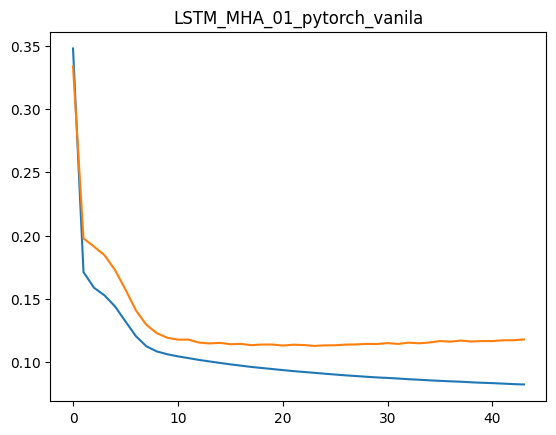

In [20]:
lsLossTr = []
lsLossTe = []
bestEpoch = 0
bestLossTe = 1e6
earlyStopThresh = 20

torch.cuda.empty_cache()

with tqdm.trange(nEpochs, unit='epoch', mininterval=0) as progBar:

    for iEpoch in progBar:

        # Training
        model.train()
        for xBatchTr, yBatchTr in loaderTrain:
            model = model.to(device)
            xBatchTr = xBatchTr.to(device)
            yBatchTr = yBatchTr.to(device)
            yPredBaTr = model(xBatchTr)
            lossBaTr = lossFn(yPredBaTr, yBatchTr)
            optimizer.zero_grad()
            lossBaTr.backward()
            optimizer.step()

        # Evaluation of Testing
        model.eval()
        with torch.no_grad():
            model = model.to('cpu')
            xTrainTs = xTrainTs.to('cpu')
            yTrainTs = yTrainTs.to('cpu')
            xTestTs = xTestTs.to('cpu')
            yTestTs = yTestTs.to('cpu')
            yPredTr = model(xTrainTs)
            lossTr = np.sqrt(lossFn(yPredTr, yTrainTs))
            yPredTe = model(xTestTs)
            lossTe = np.sqrt(lossFn(yPredTe, yTestTs))

        progBar.set_description(f"Epoch {iEpoch}: train RMSE {lossTr:.6f}, test RMSE {lossTe:.6f}")
        progBar.update(1)

        if iEpoch % 100 == 0:
            progBar.write(f"Epoch {iEpoch}: train RMSE {lossTr:.6f}, test RMSE {lossTe:.6f}")

        if lossTe < bestLossTe:
            bestEpoch = iEpoch
            bestLossTe = lossTe
            torch.save(model.state_dict(), f"{modelDir}/best_model.pth")
            torch.save(
                {
                    'epoch': iEpoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': lossTe
                    },
                f"{checkpointDir}/best_model_state.tar"
            )

        elif iEpoch - bestEpoch > earlyStopThresh:
            progBar.write(f"Training stop because testing loss has not decreased for {earlyStopThresh} epochs")
            break

        lsLossTr.append(lossTr)
        lsLossTe.append(lossTe)

        # save the losses
        loss_data = {
            "training_loss": lsLossTr,
            "testing_loss": lsLossTe
        }
        loss_df = pd.DataFrame(loss_data)
        loss_df.to_csv(f"{lossDir}/losses.csv")

plt.plot(loss_df)
plt.title(f"{version}")
plt.savefig(f"{learingCurveDir}/learning_curve.png")


### Training with second half

In [21]:
# Use the first dataset first
if spliDataset2Half:
    xTrainTs = torch.Tensor(x_train_2)
    yTrainTs = torch.Tensor(y_train_2)
    xTestTs = torch.Tensor(x_test)
    yTestTs = torch.Tensor(y_test)
else:
    xTrainTs = torch.Tensor(x_train)
    yTrainTs = torch.Tensor(y_train)
    xTestTs = torch.Tensor(x_test)
    yTestTs = torch.Tensor(y_test)

### Data Loader ###
params = {'shuffle': True, 'batch_size': batchSz}

if spliDataset2Half:
    loaderTrain = DataLoader(DSet(x_train_2, y_train_2), **params)
    loaderTest = DataLoader(DSet(x_test, y_test), **params)
else:
    print("Do not run the following cells.")

    

Epoch 0: train RMSE 0.095197, test RMSE 0.121693:   0%|          | 1/1000 [03:30<58:17:24, 210.05s/epoch]

Epoch 0: train RMSE 0.095197, test RMSE 0.121693


Epoch 44: train RMSE 0.074079, test RMSE 0.117210:   4%|▍         | 44/1000 [2:36:30<56:40:35, 213.43s/epoch]

Training stop because testing loss has not decreased for 20 epochs


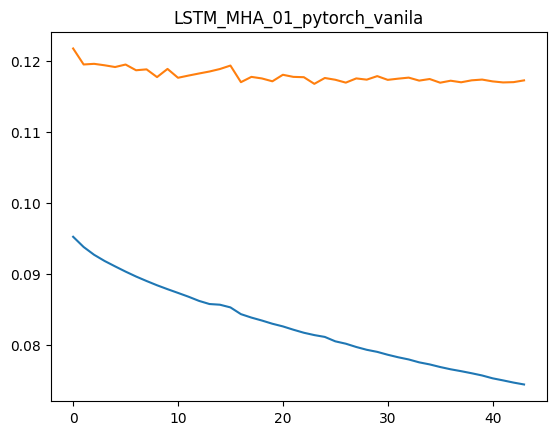

In [22]:
lsLossTr = []
lsLossTe = []
bestEpoch = 0
bestLossTe = 1e6
earlyStopThresh = 20

torch.cuda.empty_cache()

with tqdm.trange(nEpochs, unit='epoch', mininterval=0) as progBar:

    for iEpoch in progBar:

        # Training
        model.train()
        for xBatchTr, yBatchTr in loaderTrain:
            model = model.to(device)
            xBatchTr = xBatchTr.to(device)
            yBatchTr = yBatchTr.to(device)
            yPredBaTr = model(xBatchTr)
            lossBaTr = lossFn(yPredBaTr, yBatchTr)
            optimizer.zero_grad()
            lossBaTr.backward()
            optimizer.step()

        # Evaluation of Testing
        model.eval()
        with torch.no_grad():
            model = model.to('cpu')
            xTrainTs = xTrainTs.to('cpu')
            yTrainTs = yTrainTs.to('cpu')
            xTestTs = xTestTs.to('cpu')
            yTestTs = yTestTs.to('cpu')
            yPredTr = model(xTrainTs)
            lossTr = np.sqrt(lossFn(yPredTr, yTrainTs))
            yPredTe = model(xTestTs)
            lossTe = np.sqrt(lossFn(yPredTe, yTestTs))

        progBar.set_description(f"Epoch {iEpoch}: train RMSE {lossTr:.6f}, test RMSE {lossTe:.6f}")
        progBar.update(1)

        if iEpoch % 100 == 0:
            progBar.write(f"Epoch {iEpoch}: train RMSE {lossTr:.6f}, test RMSE {lossTe:.6f}")

        if lossTe < bestLossTe:
            bestEpoch = iEpoch
            bestLossTe = lossTe
            torch.save(model.state_dict(), f"{modelDir}/best_model_2.pth")
            torch.save(
                {
                    'epoch': iEpoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': lossTe
                    },
                f"{checkpointDir}/best_model_state_2.tar"
            )

        elif iEpoch - bestEpoch > earlyStopThresh:
            progBar.write(f"Training stop because testing loss has not decreased for {earlyStopThresh} epochs")
            break

        lsLossTr.append(lossTr)
        lsLossTe.append(lossTe)

        # save the losses
        loss_data = {
            "training_loss": lsLossTr,
            "testing_loss": lsLossTe
        }
        loss_df = pd.DataFrame(loss_data)
        loss_df.to_csv(f"{lossDir}/losses_2.csv")

plt.plot(loss_df)
plt.title(f"{version}")
plt.savefig(f"{learingCurveDir}/learning_curve_2.png")


# Generate predictions

In [17]:
loadModel = True
model = LstmMHAModel()
model.load_state_dict(torch.load("models/LSTM_MHA_01_pytorch_vanila/best_model.pth"))

<All keys matched successfully>

### Feedforward predictions

In [20]:
predPlotDir = f"{parentDir}prediction/{version}/plots/feedforward"
predCsvDir = f"{parentDir}prediction/{version}/csv/feedforward"
rmseCsvDdir = f"{parentDir}prediction/{version}/rmse/feedforward"
pathlib.Path(predPlotDir).mkdir(parents=True, exist_ok=True)
pathlib.Path(predCsvDir).mkdir(parents=True, exist_ok=True)
pathlib.Path(rmseCsvDdir).mkdir(parents=True, exist_ok=True)

In [35]:
rmseLs = list()

for file in valid_data_files:
    sensor_df, status = D01_1_DataPreparation.loadDataset(f"{preparedDataDir}/sensor data/{file}", Z01_1_General.DATEFORMAT)
    df = scaleData(sensor_df, lsScalers)

    x_data, y_data = D01_1_DataPreparation.transformDataSingleStep(df, n_steps)

    x_data = torch.Tensor(x_data).to(device)

    y_pred = model(x_data)

    y_pred = y_pred.detach().numpy()

    y_pred = pd.DataFrame(y_pred, columns=df.columns)
    y_true = pd.DataFrame(y_data, columns=df.columns)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 20))

    ax1.plot(y_pred, color='orange', label='prediction')
    ax1.plot(y_true, color='blue', label='actual')

    y_pred = descaleData(y_pred, lsScalers)
    y_true = descaleData(y_true, lsScalers)

    ax2.plot(y_pred, color='orange', label='prediction')
    ax2.plot(y_true, color='blue', label='actual')

    plt.suptitle(file)
    plt.savefig(f"{predPlotDir}/{file[:-4]}.png")
    plt.close()

    rmse = list()
    for col in y_true.columns:
        mse = mean_squared_error(y_true[col], y_pred[col])
        rmse.append(np.sqrt(mse))
    rmseLs.append(rmse)

    y_pred.to_csv(f"{predCsvDir}/{file[:-4]}.csv")

rmse_df = pd.DataFrame(rmseLs)
rmse_df.columns = y_true.columns
rmse_df["files"] = valid_data_files
rmse_df.to_csv(f"{rmseCsvDdir}/rmse.csv")

### Feedback predictions

In [36]:
predPlotDir = f"{parentDir}prediction/{version}/plots/feedback"
predCsvDir = f"{parentDir}prediction/{version}/csv/feedback"
rmseCsvDdir = f"{parentDir}prediction/{version}/rmse/feedback"
pathlib.Path(predPlotDir).mkdir(parents=True, exist_ok=True)
pathlib.Path(predCsvDir).mkdir(parents=True, exist_ok=True)
pathlib.Path(rmseCsvDdir).mkdir(parents=True, exist_ok=True)

In [38]:
rmseLs = list()

for file in valid_data_files:
    sensor_df, status = D01_1_DataPreparation.loadDataset(f"{preparedDataDir}/sensor data/{file}", Z01_1_General.DATEFORMAT)

    df = scaleData(sensor_df, lsScalers)

    x_data, y_data = D01_1_DataPreparation.transformDataSingleStep(df, n_steps)

    y_pred = list()
    curr_in = x_data[0]
    curr_in = curr_in.reshape([1, curr_in.shape[0], curr_in.shape[1]])
    curr_in = torch.Tensor(curr_in)
    curr_out = model(curr_in)
    curr_in = curr_in.reshape([curr_in.shape[1], curr_in.shape[2]])
    curr_in = curr_in.detach().numpy()
    curr_out = curr_out.detach().numpy()

    y_pred.append(curr_out.flatten())

    for n in range(len(x_data)-1):
        curr_in = np.concatenate([curr_in, curr_out], axis=0)
        curr_in = curr_in[1:, :]
        curr_in = curr_in.reshape([1, curr_in.shape[0], curr_in.shape[1]])
        curr_in = torch.Tensor(curr_in).to(device)
        curr_out = model(curr_in)
        curr_in = curr_in.reshape([curr_in.shape[1], curr_in.shape[2]])
        curr_in = curr_in.detach().numpy()
        curr_out = curr_out.detach().numpy()
        y_pred.append(curr_out.flatten())
    
    y_pred = pd.DataFrame(y_pred, columns=df.columns)
    y_true = pd.DataFrame(y_data, columns=df.columns)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 20))

    ax1.plot(y_pred, color='orange', label='prediction')
    ax1.plot(y_true, color='blue', label='actual')

    y_pred = descaleData(y_pred, lsScalers)
    y_true = descaleData(y_true, lsScalers)

    ax2.plot(y_pred, color='orange', label='prediction')
    ax2.plot(y_true, color='blue', label='actual')

    plt.suptitle(file)
    plt.savefig(f"{predPlotDir}/{file[:-4]}.png")
    plt.close()
    
    rmse = list()
    for col in y_true.columns:
        mse = mean_squared_error(y_true[col], y_pred[col])
        rmse.append(np.sqrt(mse))
    rmseLs.append(rmse)

    y_pred.to_csv(f"{predCsvDir}/{file[:-4]}.csv")


rmse_df = pd.DataFrame(rmseLs)
rmse_df.columns = y_true.columns
rmse_df["files"] = valid_data_files
rmse_df.to_csv(f"{rmseCsvDdir}/rmse.csv")